<a href="https://www.kaggle.com/code/mashallandme/eda-nn-with-embedding-by-fastai?scriptVersionId=190656680" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Background

The objective of this competition is to predict which customers respond positively to an automobile insurance offer.

## Import packages

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from scipy.stats import chi2_contingency
from fastai.tabular.all import *
from sklearn.preprocessing import MaxAbsScaler,OneHotEncoder,LabelEncoder,StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

2024-07-31 21:44:08.085836: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 21:44:08.085966: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 21:44:08.231627: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/playground-series-s4e7/sample_submission.csv
/kaggle/input/playground-series-s4e7/train.csv
/kaggle/input/playground-series-s4e7/test.csv


## Load data and EDA

In [2]:
train_df = pd.read_csv('/kaggle/input/playground-series-s4e7/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s4e7/test.csv')
submission = pd.read_csv('/kaggle/input/playground-series-s4e7/sample_submission.csv')

### Check the data: Null values, duplicates, and distributions

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11504798 entries, 0 to 11504797
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Gender                object 
 2   Age                   int64  
 3   Driving_License       int64  
 4   Region_Code           float64
 5   Previously_Insured    int64  
 6   Vehicle_Age           object 
 7   Vehicle_Damage        object 
 8   Annual_Premium        float64
 9   Policy_Sales_Channel  float64
 10  Vintage               int64  
 11  Response              int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 1.0+ GB


In [4]:
train_df.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [5]:
train_df.duplicated().sum()

0

In [6]:
train_df.head(10)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0
5,5,Female,31,1,47.0,1,< 1 Year,No,28150.0,152.0,197,0
6,6,Male,23,1,45.0,1,< 1 Year,No,27128.0,152.0,190,0
7,7,Female,47,1,8.0,0,1-2 Year,Yes,40659.0,26.0,262,1
8,8,Female,26,1,28.0,1,< 1 Year,No,31639.0,152.0,36,0
9,9,Female,66,1,11.0,0,1-2 Year,Yes,2630.0,26.0,125,0


From the outputs above, we observe the following:
- Continuous variables: Age, Vintage, and Annual_Premium.
- Categorical variables: Gender, Driving_License, Region_Code, Previously_Insured, Vehicle_Age, Vehicle_Damage, and Policy_Sales_Channel.
- No null values.
- No duplicates.

### Check the variable distributions and correlations

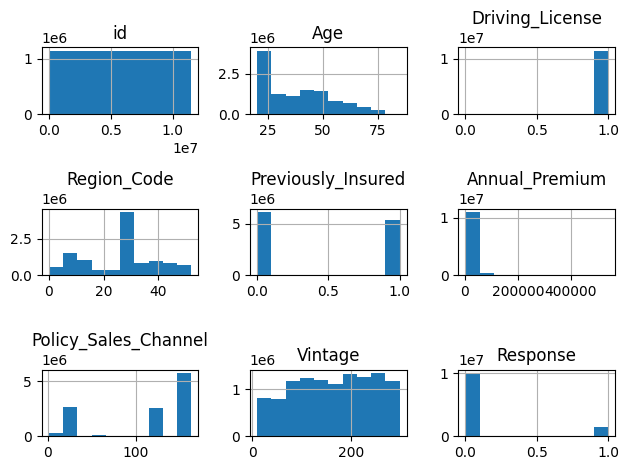

In [7]:
hist = train_df.hist()
plt.tight_layout()

<Axes: >

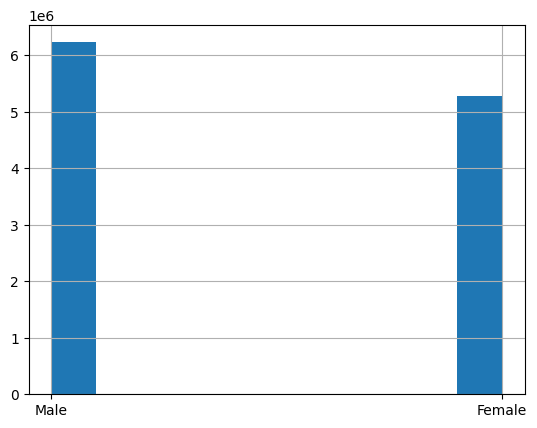

In [8]:
train_df['Gender'].hist()

<Axes: >

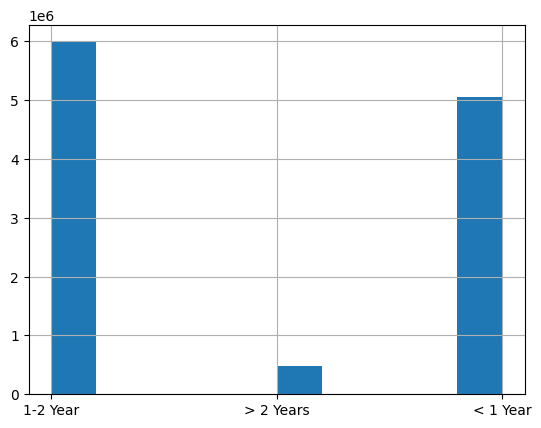

In [9]:
train_df['Vehicle_Age'].hist()

<Axes: >

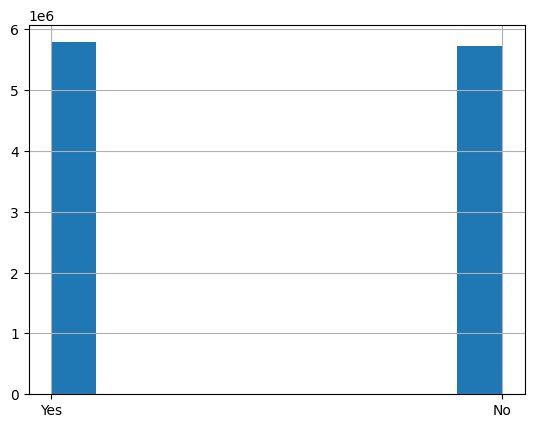

In [10]:
train_df['Vehicle_Damage'].hist()

<Axes: >

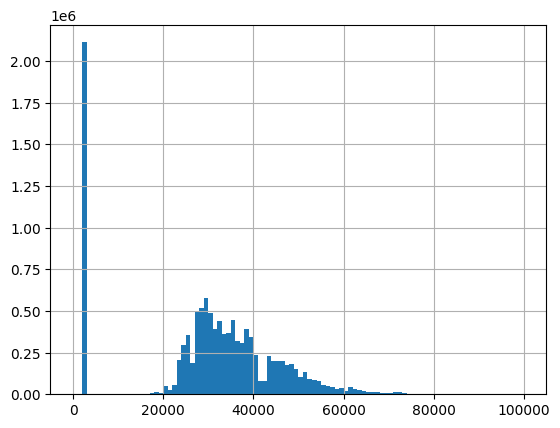

In [11]:
train_df['Annual_Premium'].hist(bins=100,range=[0,1e5])

There is a isolated group in the distribution of "Annual_Premium". Let's check closer.

<Axes: >

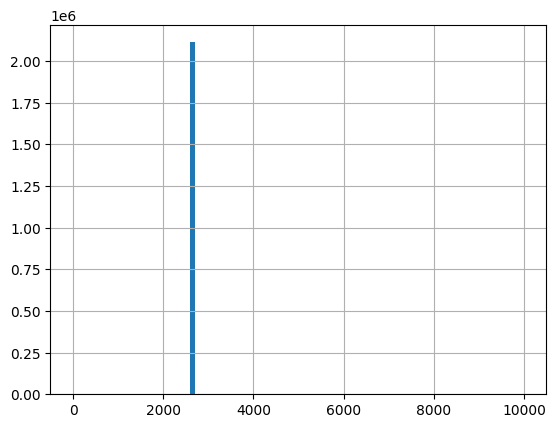

In [12]:
train_df['Annual_Premium'].hist(bins=100,range=[0,1e4])

In [13]:
cols = train_df.columns
for col in cols[1:]:
    print(train_df[col].value_counts(normalize=True))
    print()

Gender
Male      0.541351
Female    0.458649
Name: proportion, dtype: float64

Age
24    7.091685e-02
23    6.521610e-02
22    5.747480e-02
25    5.525321e-02
21    4.374783e-02
          ...     
81    2.659760e-05
82    1.477644e-05
83    7.040541e-06
84    3.042209e-06
85    7.822823e-07
Name: proportion, Length: 66, dtype: float64

Driving_License
1    0.998022
0    0.001978
Name: proportion, dtype: float64

Region_Code
28.0    2.999672e-01
8.0     8.874871e-02
46.0    5.025799e-02
41.0    4.846508e-02
15.0    3.511378e-02
30.0    3.192642e-02
29.0    2.939174e-02
50.0    2.627895e-02
11.0    2.418652e-02
36.0    2.276841e-02
3.0     2.140872e-02
33.0    2.019914e-02
47.0    1.992125e-02
35.0    1.738709e-02
6.0     1.574317e-02
45.0    1.384570e-02
37.0    1.381823e-02
18.0    1.291183e-02
39.0    1.200091e-02
14.0    1.169816e-02
21.0    1.102088e-02
10.0    1.095899e-02
2.0     1.026502e-02
48.0    9.928901e-03
13.0    9.460227e-03
9.0     8.115831e-03
7.0     8.017525e-03
12.0 

- Majority of the customers are males (~54%).
- The distribution of Age is right skewed.
- A small percent of customers having no driver license (<0.01%).
- Region code 28.0 is most frequent.
- ~46% of the customers are previously insured.
- ~95% of the customers with vehicals age <=2 years.
- ~50% of the customers with vehical damaged history.
- The distribution of "Annual-Premium is slightly right skewed but with an islated value 2,630.
- 152.0, 26.0, and 124.0 are the leading policy sales channels.
- Vintage is close to uniform ditributed.
- The response variable shows imbalance, 12% response rate. 

Let's check he correlations of the features to the response variable. We are going to use Cramér's V to evaluation the correlations of the categorical variables.

In [14]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [15]:
train_df.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

In [16]:
corr_list = [cramers_v(train_df[col], train_df['Response']) for col in train_df.columns[1:-1]]

In [17]:
corr_wt_response = {'col_name':train_df.columns[1:-1],'correlation':corr_list}
corr_wt_response = pd.DataFrame(corr_wt_response)

In [18]:
corr_wt_response = {'col_name':train_df.columns[1:-1],'correlation':corr_list}
corr_wt_response = pd.DataFrame(corr_wt_response)
sorted_corr=corr_wt_response.sort_values('correlation',ascending=False)

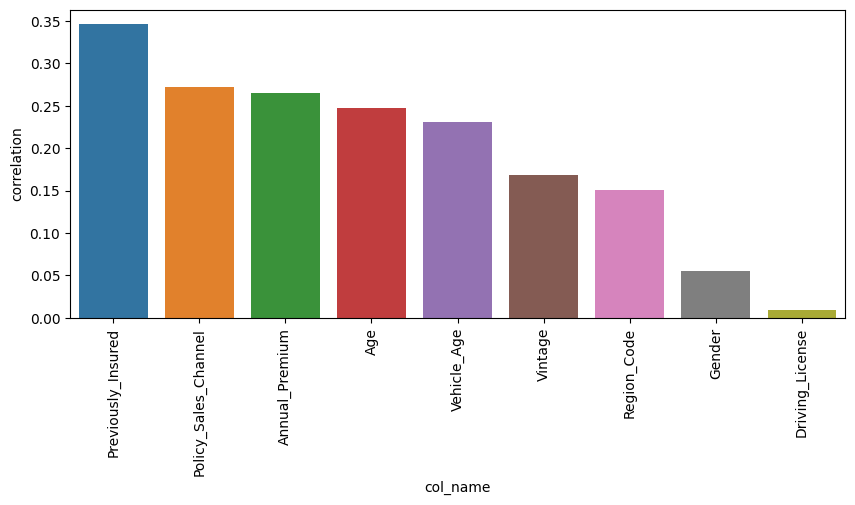

In [19]:
plt.figure(figsize=(10,4))
sns.barplot(x=sorted_corr['col_name'][1:],y=sorted_corr['correlation'][1:])
plt.xticks(rotation=90)
plt.show()

"Vehicle_Damage" and "Previously_Insured" are leading features most correlated with the response variable.

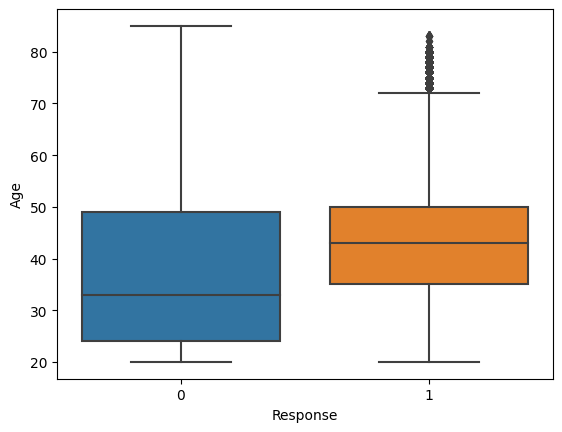

In [20]:
sns.boxplot(x='Response', y='Age', data=train_df)
plt.show()

Age of people who responded has a lager median value than the people who didn't respond.

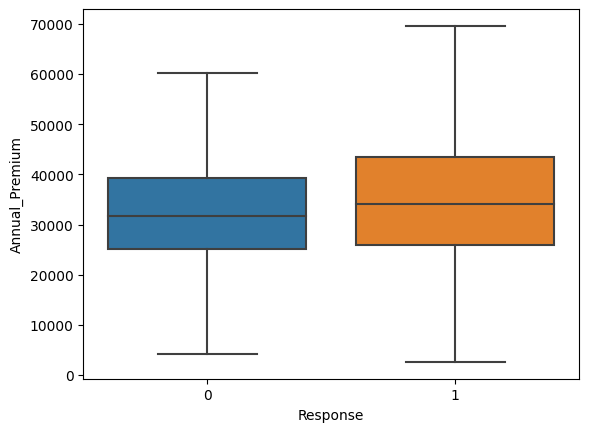

In [21]:
sns.boxplot(x='Response', y='Annual_Premium', data=train_df,showfliers=False)
plt.show()

People who responded pay more annual premium in general.

<Axes: xlabel='Region_Code', ylabel='Count'>

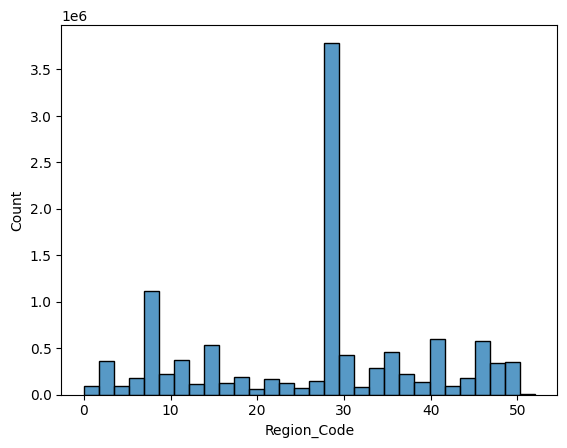

In [22]:
sns.histplot(x=train_df['Region_Code'], bins=30)

<Axes: xlabel='Policy_Sales_Channel', ylabel='Count'>

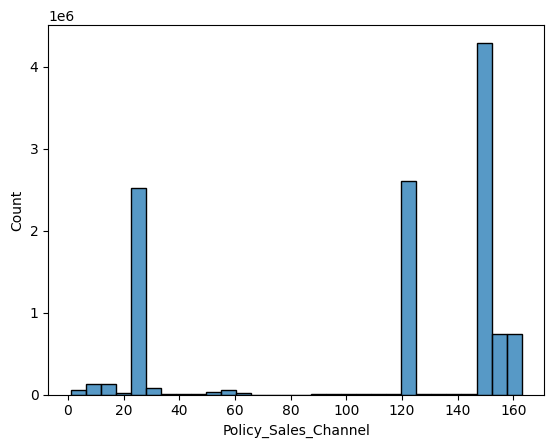

In [23]:
sns.histplot(x=train_df['Policy_Sales_Channel'],bins=30)

"Region_Code" and "Policy_Sales_Channel" are categorical variables with many distinct values. If use one-hot encoding directly, it will increase the data size and sparsity dramatically. Moreover, one-hot encoding cannot capture the potential relationship between the data as it creates independent columns. One approach is to find approprite groups and use the groups as new derived feature. The other way is to use embbedings.

## Modeling

### Without embedding

The following code uses the rules to find the groups in "Region_Code" and "Policy_Sales_Channel". We built a simple NN for the classification.

In [24]:
# First I tried to regroup these two variables based on the histogram plot above.
region_breaks = [0,15,25,35,55]
train_df['region_groups'] = pd.cut(
    train_df['Region_Code'],
    bins=region_breaks,
    labels=[0, 1, 2, 3],
    include_lowest=True)
test_df['region_groups'] = pd.cut(
    test_df['Region_Code'],
    bins=region_breaks,
    labels=[0, 1, 2, 3],
    include_lowest=True)
policy_breaks = [0,40,80,140,170]
train_df['policy_groups'] = pd.cut(
    train_df['Policy_Sales_Channel'],
    bins=policy_breaks,
    labels=[0, 1, 2, 3],
    include_lowest=True)
test_df['policy_groups'] = pd.cut(
    test_df['Policy_Sales_Channel'],
    bins=policy_breaks,
    labels=[0, 1, 2, 3],
    include_lowest=True)

Then, we can perform label encoding for the categorical variables.

In [25]:
X = train_df.drop(['id','Response','Region_Code','Policy_Sales_Channel'],axis=1)
y = train_df['Response']
X_test_submit = test_df.drop(['id','Region_Code','Policy_Sales_Channel'],axis=1)
label_encoder = LabelEncoder()
label_encoder.fit(X['Gender'])
X['Gender'] = label_encoder.transform(X['Gender'])
X_test_submit['Gender']=label_encoder.transform(X_test_submit['Gender'])
label_encoder.fit(X['Vehicle_Damage'])
X['Vehicle_Damage'] = label_encoder.transform(X['Vehicle_Damage'])
X_test_submit['Vehicle_Damage']=label_encoder.transform(X_test_submit['Vehicle_Damage'])
order_mapping = {'1-2 Year': 1, '< 1 Year': 0, '> 2 Years': 2}
X['Vehicle_Age'] = X['Vehicle_Age'].map(order_mapping)
X_test_submit['Vehicle_Age'] = X_test_submit['Vehicle_Age'].map(order_mapping)
standard_scaler = StandardScaler()
X[['Age', 'Annual_Premium', 'Vintage']] = standard_scaler.fit_transform(X[['Age', 'Annual_Premium', 'Vintage']])
X_test_submit[['Age', 'Annual_Premium', 'Vintage']] = standard_scaler.transform(X_test_submit[['Age', 'Annual_Premium', 'Vintage']])
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=32)

Nest, let's construct the NN using tensorflow framework.

In [26]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(60, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(30, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(1,activation='sigmoid') 
])

In [27]:
METRICS = [
      tf.keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      tf.keras.metrics.MeanSquaredError(name='Brier score'),
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [28]:
model.compile(optimizer='adam',
              loss='BinaryCrossentropy',
              metrics=METRICS)

In [29]:
#model_history = model.fit(X_train,y_train,epochs=4,batch_size=256,validation_data=(X_val, y_val),validation_batch_size=64)

The model output:


Epoch 1/4

33706/33706 ━━━━━━━━━━━━━━━━━━━━ 230s 7ms/step - Brier score: 0.0896 - accuracy: 0.8767 - auc: 0.8405 - cross entropy: 0.2760 - fn: 526093.3125 - fp: 6121.9004 - loss: 0.2760 - prc: 0.3303 - precision: 0.4073 - recall: 0.0072 - tn: 3778080.0000 - tp: 4328.7290 - val_Brier score: 0.0875 - val_accuracy: 0.8771 - val_auc: 0.8553 - val_cross entropy: 0.2666 - val_fn: 353568.0000 - val_fp: 0.0000e+00 - val_loss: 0.2666 - val_prc: 0.3637 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 2522632.0000 - val_tp: 0.0000e+00

Epoch 2/4

33706/33706 ━━━━━━━━━━━━━━━━━━━━ 235s 7ms/step - Brier score: 0.0894 - accuracy: 0.8764 - auc: 0.8436 - cross entropy: 0.2751 - fn: 524440.6250 - fp: 8463.1289 - loss: 0.2751 - prc: 0.3388 - precision: 0.4332 - recall: 0.0122 - tn: 3775243.0000 - tp: 6477.1816 - val_Brier score: 0.0874 - val_accuracy: 0.8771 - val_auc: 0.8557 - val_cross entropy: 0.2666 - val_fn: 353568.0000 - val_fp: 0.0000e+00 - val_loss: 0.2666 - val_prc: 0.3666 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 2522632.0000 - val_tp: 0.0000e+00

Epoch 3/4

33706/33706 ━━━━━━━━━━━━━━━━━━━━ 248s 7ms/step - Brier score: 0.0894 - accuracy: 0.8764 - auc: 0.8438 - cross entropy: 0.2751 - fn: 523532.9688 - fp: 8977.9531 - loss: 0.2751 - prc: 0.3400 - precision: 0.4482 - recall: 0.0137 - tn: 3774853.5000 - tp: 7259.5850 - val_Brier score: 0.0873 - val_accuracy: 0.8771 - val_auc: 0.8561 - val_cross entropy: 0.2665 - val_fn: 353568.0000 - val_fp: 0.0000e+00 - val_loss: 0.2665 - val_prc: 0.3673 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 2522632.0000 - val_tp: 0.0000e+00

Epoch 4/4

33706/33706 ━━━━━━━━━━━━━━━━━━━━ 272s 7ms/step - Brier score: 0.0892 - accuracy: 0.8766 - auc: 0.8441 - cross entropy: 0.2747 - fn: 523279.7188 - fp: 9254.2480 - loss: 0.2747 - prc: 0.3403 - precision: 0.4450 - recall: 0.0140 - tn: 3774643.7500 - tp: 7446.1885 - val_Brier score: 0.0872 - val_accuracy: 0.8771 - val_auc: 0.8560 - val_cross entropy: 0.2661 - val_fn: 353562.0000 - val_fp: 2.0000 - val_loss: 0.2661 - val_prc: 0.3671 - val_precision: 0.7500 - val_recall: 1.6970e-05 - val_tn: 2522630.0000 - val_tp: 6.0000

The model accuracy is 0.8766 on training data and 0.8771 on validation data.

### With embedding

Below is how we can use the tabular modeling from fastai to build NN with embeddings.

In [30]:
X_train = train_df.drop(['id'],axis=1)
X_test = test_df.drop(['id'],axis=1)

In [31]:
X_train['Response']=X_train['Response'].astype(str)
X_train['Region_Code']=X_train['Region_Code'].astype(str)
X_train['Policy_Sales_Channel']=X_train['Policy_Sales_Channel'].astype(str)
X_test['Region_Code']=X_test['Region_Code'].astype(str)
X_test['Policy_Sales_Channel']=X_test['Policy_Sales_Channel'].astype(str)

In [32]:
order_mapping = {'Yes': 1, 'No': 0}
X_train['Vehicle_Damage']=X_train['Vehicle_Damage'].map(order_mapping)
X_test['Vehicle_Damage']=X_test['Vehicle_Damage'].map(order_mapping)

In [33]:
order_mapping = {'1-2 Year': 1, '< 1 Year': 0, '> 2 Years': 2}
X_train['Vehicle_Age'] = X_train['Vehicle_Age'].map(order_mapping)
X_test['Vehicle_Age'] = X_test['Vehicle_Age'].map(order_mapping)

In [34]:
splits = RandomSplitter(valid_pct=0.25)(range_of(X_train))

In [35]:
to = TabularPandas(X_train, procs=[Categorify, FillMissing, Normalize],
                   cat_names = ['Gender', 'Region_Code', 'Policy_Sales_Channel'],
                   cont_names = ['Age', 'Annual_Premium', 'Vintage','Vehicle_Age', 'Driving_License','Previously_Insured', 'Vehicle_Damage'],
                   y_names='Response',
                   splits=splits)

Consider 'Vehicle_Age', 'Driving_License','Previously_Insured' and 'Vehicle_Damage' as continuous features.

In [36]:
to.xs.iloc[:5]

,Gender,Region_Code,Policy_Sales_Channel,Age,Annual_Premium,Vintage,Vehicle_Age,Driving_License,Previously_Insured,Vehicle_Damage
447061,1,47,64,-1.226127,-1.692204,-1.261494,-1.062053,0.044533,-0.928453,0.994590
8618838,2,38,55,-0.959294,-0.173448,-1.073947,-1.062053,0.044533,1.077061,-1.005439
9334498,1,12,76,-0.025377,-1.692204,0.501445,0.698642,0.044533,-0.928453,0.994590
9938122,2,22,29,0.441581,0.356356,-1.048941,0.698642,0.044533,1.077061,-1.005439
8873233,2,22,76,1.975873,-0.095008,-0.361270,0.698642,0.044533,-0.928453,0.994590


In [37]:
dls = to.dataloaders(bs=2048)

In [38]:
learn = tabular_learner(dls, metrics=accuracy)

In [39]:
learn

In [40]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.262503,0.262439,0.877063,01:44
1,0.261100,0.260203,0.877110,01:43
2,0.259852,0.259724,0.877287,01:43
3,0.259157,0.259497,0.877294,01:43
4,0.260749,0.259354,0.877319,01:44


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

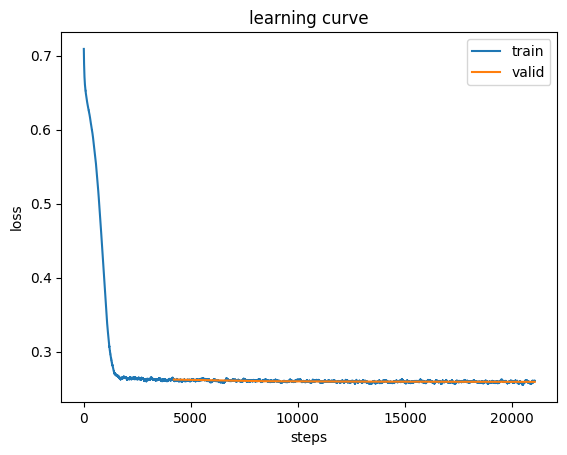

In [41]:
learn.recorder.plot_loss()

In [42]:
dl = learn.dls.test_dl(X_test)

In [43]:
y_test_pred,targs=learn.get_preds(dl=dl)

In [44]:
submission['Response'] = y_test_pred.numpy()[:,1]
submission.to_csv('submission.csv', index=False)